In [8]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from collections import deque
import glob
import imageio
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline




In [9]:
# load pickled distortion matrix
with open('camera_cal/output/cal_dist_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [24]:
# Read in an image
#img = cv2.imread('test_image.png')

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

In [25]:
# Convert to grayscale
def to_grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    return gray

In [26]:
def abs_sobel_thresh(img, orient='x', thresh_min=85, thresh_max=195):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sobel_binary

In [27]:
def rgb_thresh(img):
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    return r_g_condition

In [28]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Create a binary mask where direction thresholds are met # no scaling
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary

In [33]:
def hls_select(img, s_thresh=(110, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # Apply a threshold to the S channel
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Return a binary image of threshold result
    #binary_hls[((s_binary == 1))] =1

    return s_binary

In [82]:
def mask_ROI(image):
    # apply the region of interest mask
    height,width,_ = image.shape
    print(image.shape,height,width)
    mask = np.zeros_like(image)
    #region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    region_of_interest_vertices = np.array( [[(width/7, height),(0.4*width, 0.6*height),(0.6*width, 0.6*height),(0.92*width, height)]], dtype=np.int32 )
    cv2.fillPoly(mask, [region_of_interest_vertices], (255,255,255))
    plt.imshow(mask)
    ROI_thresholded = cv2.bitwise_and(image, mask)
    return ROI_thresholded

In [83]:
def perspactive_transform(img, warp=True):
    offset = [150,0] # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # define 4 corners of ROI
    #corners = np.float32([[190,720],[589,470],[698,470],[1145,720]])
    corners = np.float32([[200,720],[570,470],[722,470],[1130,720]])
    # define 4 
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[320,720], [320,1], [920, 1], [920, 720]])    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    if warp:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M

(720, 1280, 3) 720 1280
(720, 1280, 3) 720 1280


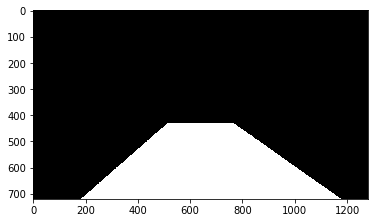

In [89]:
#img=mpimg.imread('./test_images/straight_lines1.jpg')
img=plt.imread('./test_images/test5.jpg')

undistorted = cal_undistort(img)


# Apply each of the thresholding functions
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements
gray = to_grayscale(img)
gradx = abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255)
grady = abs_sobel_thresh(gray, orient='y', thresh_min=5, thresh_max=95)
rgb_binary = rgb_thresh(img)
dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=(0.7, 1.3))
binary_hls = hls_select(img, s_thresh=(150, 255))

channels = 255*np.dstack(( np.zeros_like(gradx), gradx, binary_hls)).astype('uint8')  

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (binary_hls == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) & (dir_binary == 1)) | ((binary_hls == 1) & (rgb_binary == 1))] = 1
#combined[(binary_hls == 1) & (grady == 1) | (gradx == 1)] = 1
combined = 255*np.dstack((combined,combined,combined)).astype('uint8')

image_ROI = mask_ROI(combined)
image_ROI = to_grayscale(image_ROI)
orig_ROI = mask_ROI(img)

warped, M = perspactive_transform(image_ROI)
warped_orig, M2 = perspactive_transform(orig_ROI)

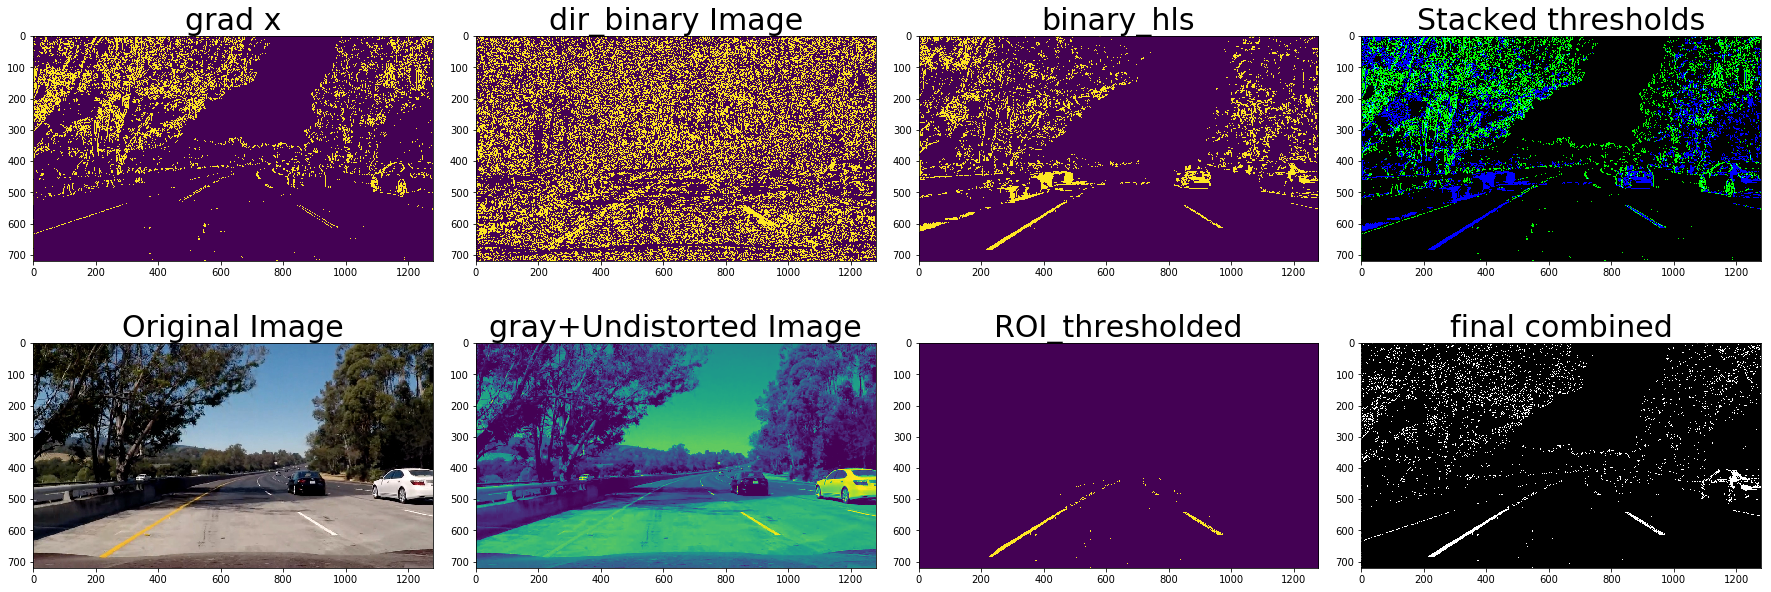

In [90]:
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(gradx)
ax1.set_title('grad x', fontsize=30)
ax2.imshow(dir_binary)
ax2.set_title('dir_binary Image', fontsize=30)
ax3.imshow(binary_hls)
ax3.set_title('binary_hls', fontsize=30)
ax4.imshow(channels)
ax4.set_title('Stacked thresholds', fontsize=30)
ax5.imshow(img)
ax5.set_title('Original Image', fontsize=30)
ax6.imshow(gray)
ax6.set_title('gray+Undistorted Image', fontsize=30)
ax7.imshow(image_ROI)
ax7.set_title('ROI_thresholded', fontsize=30)
ax8.imshow(combined)
ax8.set_title('final combined', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

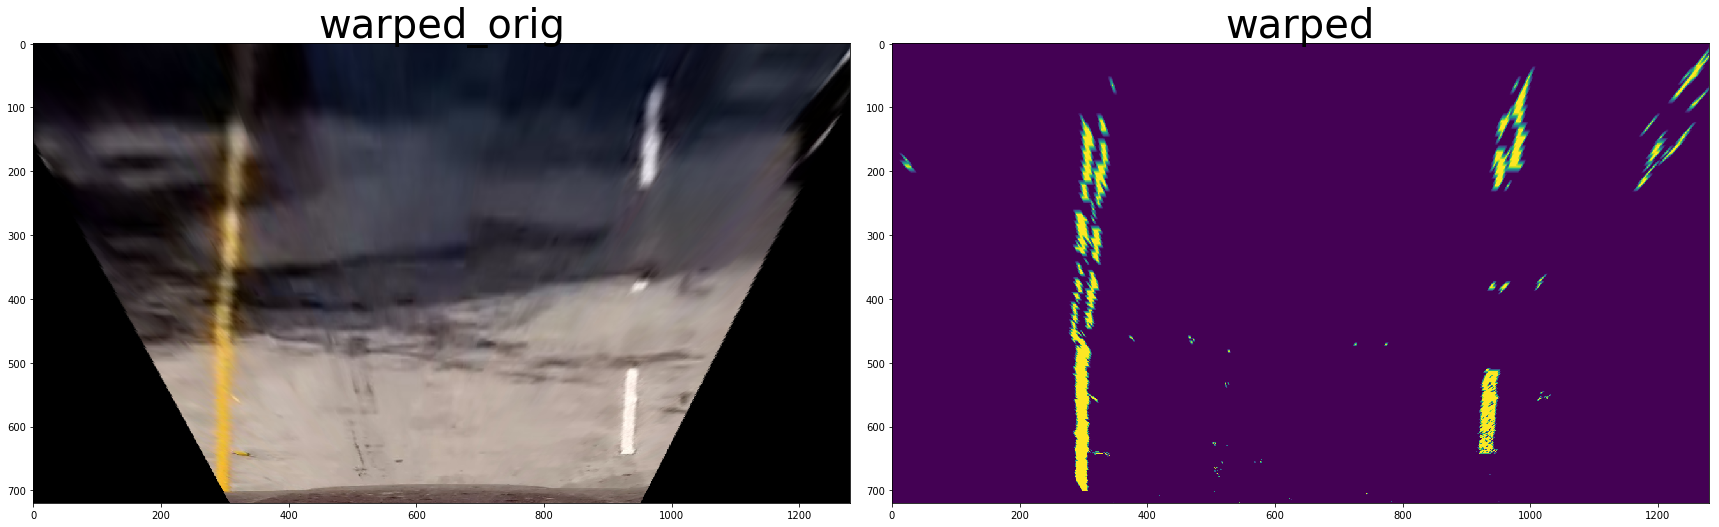

In [91]:
# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped_orig)
ax1.set_title('warped_orig', fontsize=40)

ax2.imshow(warped)
ax2.set_title('warped', fontsize=40)

# Histogram
The peaks int the histogram tell us about the likely position of the lanes in the image.

291 933


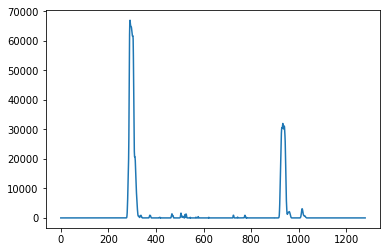

In [100]:
binary_warped = np.copy(warped)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base, rightx_base)
plt.plot(histogram)

In [110]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

#print(len(left_lane_inds[0]),len(left_lane_inds[8]))  # 0,1,2..8 windows
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
#print(len(left_lane_inds))

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

(720, 0)

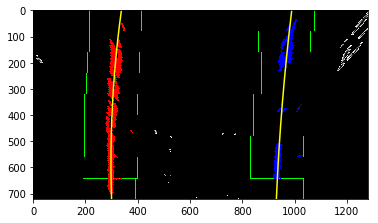

In [102]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)